## Variational AutoEncoders
Variational AutoEncoders (VAEs) are complex neural networks. They work as both semi-supervised models or unsupervised generative models. For more detailed information check out the "WhatAre" VAEs notebook. For this notebook, make sure to pay attention to each unique function in the VAE class. Especially note the `reparameterize()` function and the return type from the standard `forward()` pass. This is where the variational inferencing (from the name of the model) takes place.

Also, make sure you note the new loss function defined before training. It's optimizing the spread caused by KL Divergence and the standard MSE loss.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from typing import List, Union, Any


class VAE(nn.Module):
    def __init__(self, latent_dim: int = 4, in_channels: int = 1, hidden_dims: List[int] = None):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.hidden_dims = hidden_dims

        modules = []
        if self.hidden_dims is None:
            self.hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in self.hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv1d(self.in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            self.in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(self.hidden_dims[-1] * 10, self.latent_dim)
        self.fc_var = nn.Linear(self.hidden_dims[-1] * 10, self.latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(self.latent_dim, self.hidden_dims[-1] * 10)

        self.hidden_dims.reverse()

        for i in range(len(self.hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose1d(self.hidden_dims[i],
                                       self.hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm1d(self.hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose1d(self.hidden_dims[-1],
                               self.hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm1d(self.hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv1d(self.hidden_dims[-1], out_channels=1,
                      kernel_size=3, padding=1),
            nn.Linear(320, 300),
            nn.Tanh())

    def forward(self, x: torch.Tensor, **kwargs) -> List[Union[torch.Tensor, Any]]:
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), mu, log_var]

    def encode(self, x: torch.Tensor, **kwargs) -> List[torch.Tensor]:
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return [mu, log_var]

    def decode(self, z: torch.Tensor, **kwargs) -> torch.Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, 10)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor, **kwargs) -> torch.Tensor:
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def sample(self, num_samples: int, current_device: int, **kwargs) -> torch.Tensor:
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

    def generate(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        return self.forward(x)[0]

## Data Generation

Here we start to generate data. If you intend to use your own data skip the next 4 code blocks. This data is a set of sine waves at 5 Hz combined with pink noise from the colorednoise python library.

In [2]:
import numpy as np

frequency = 20

samples = 300

t = np.linspace(0, 1, samples)
sine = 0.1 * np.sin(frequency * 2 * np.pi * t)
print(sine.shape)

(300,)


In [3]:
!pip install colorednoise

#### Combined Noise

We have shown below what the data with a sine wave and pink noise combined looks like. It seems fairly random, but we'll see how far out ahead the LSTM can predict the small embedded sine wave correctly.

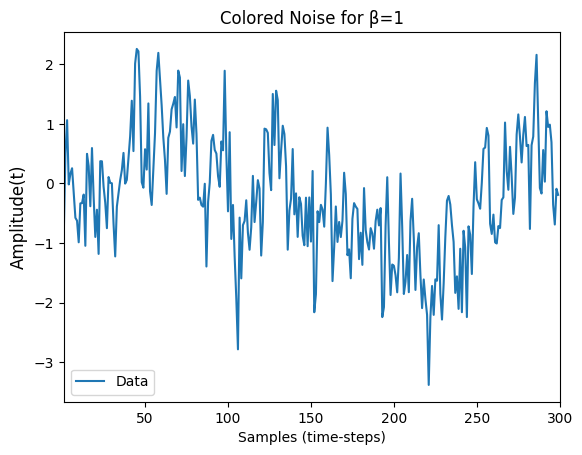

In [4]:
import colorednoise as cn
import matplotlib.pyplot as plt

beta = 1  # pink noise is 1

noise = cn.powerlaw_psd_gaussian(beta, samples)
plt.plot(noise+sine, label='Data')
plt.title('Colored Noise for β='+str(beta))
plt.xlabel('Samples (time-steps)')
plt.ylabel('Amplitude(t)', fontsize='large')
plt.xlim(1,samples)
plt.legend()
plt.show()

#### Building the Dataset

This is when we finally build the dataset. Notice how in building this we generate a signal of x2 the number of samples. This is so that we have a continuous signal where the first half can be considered input data and the second half is the corresponding sine wave.

In [5]:
data = []
labels = []
num_samples = 10000
t = np.linspace(0, 1, samples*2)
sine = 0.1 * np.sin(frequency * 2 * np.pi * t)
for i in range(num_samples):
    signal = cn.powerlaw_psd_gaussian(beta, samples*2) + sine
    data.append(signal[:samples])
    labels.append(sine[samples:])

data = np.stack(data).reshape((num_samples, 1, -1))
labels = np.stack(labels).reshape((num_samples, 1, -1))
print(data.shape)
print(labels.shape)

(10000, 1, 300)
(10000, 1, 300)


#### DataLoaders

DataLoaders are a feature of PyTorch meant to make training easier. Below we just simply split the data to be a 75% training 25% validation split and pass them to the DataLoader with the batch size and whether or not to shuffle the data. Now we are ready to look at training.

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

split_idx = int(.75 * data.shape[0])

print(split_idx)
print(data.shape)
print(labels.shape)

train_data = DataLoader(TensorDataset(torch.Tensor(data[:split_idx, :, :]), torch.Tensor(labels[:split_idx, :, :])), batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(torch.Tensor(data[split_idx:, :, :]), torch.Tensor(labels[split_idx:, :, :])), batch_size=batch_size, shuffle=False)

7500
(10000, 1, 300)
(10000, 1, 300)


#### Training and Loss

This is an example of a training loop. Notice it takes both validation and training into account. While this is not necessary, we do it just so we can run both in parallel and maximize our efficiency.

The key lines here are:
```python
loss.backward()
optimizer.step()
```
and this is what allows for training. If you notice, these are only called when using a training dataset because these two lines are the actual backpropagation and updates of the weights in the network. If these lines are not called the network does not learn. The rest is basically built around trying to help the net learn easier (updatable learning rates, loss printing, tqdm, etc.)

*Note the key differences in this loss function!!*

In [7]:
def loss_function(output: torch.Tensor, target: torch.Tensor, mu: torch.Tensor, log_var: torch.Tensor, **kwargs) -> torch.Tensor:
    kld_weight = 0.1
    recons_loss = F.mse_loss(output, target)
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - torch.clamp(log_var.exp(),
                                                                               min=0.00001,
                                                                               max=99999.), dim=1), dim=0)
    loss = recons_loss + kld_weight * kld_loss
    return loss

In [8]:
from typing import Optional, Tuple
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


def fit(model: nn.Module,
        training_loader: DataLoader,
        validation_loader: DataLoader,
        epochs: int = 50,
        device: str = 'cpu',
        write_losses: bool = False,
        save_filepath: Optional[str] = None,
        **kwargs) -> Tuple[List, List]:
    """
    Function used to fit the specified model with the provided data
    :param model: neural network pytorch model
    :param training_loader: pytorch dataloader containing the training data
    :param validation_loader: pytorch dataloader containing the validation data
    :param epochs: number of epochs to train
    :param device: which device to train the model on. Should be either "cuda:0" or "cpu"
    :param write_losses: boolean flag as to report losses during training
    :param save_filepath: path to save model, if not specified, no model is saved
    :param kwargs: "optim" optimizer,
                    "loss_function" loss function,
                    "decay_rate" decay rate,
                    "model_save_path" model save path,
                    "loss_save_path" csv save path
    :return: training and validation losses over each epoch
    """
    train_loss_list = []
    val_loss_list = []

    # splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) if 'optim' not in kwargs else kwargs.get('optim')

    decay_rate = .99995 if 'decay_rate' not in kwargs else kwargs.get('decay_rate')
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

    temp_loss = 100000000000000.0

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss = 0.0
        val_loss = 0.0

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                x = x.to(device)
                results = model(x)
                output = results[0]
                mu = results[1]
                log_var = results[2]
                y = y.to(device)
                loss = loss_function(torch.squeeze(output), torch.squeeze(y), mu, log_var)

                # backprop
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # calculating total loss
                running_loss += loss.item()

            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
            else:
                val_loss = running_loss

        # shows total loss
        if epoch % 10 == 0 and write_losses:
            tqdm.write('{} train loss: {.6f} val loss: {.6f}'.format(epoch + 1, train_loss, val_loss))

        # saving best model
        if train_loss < temp_loss and save_filepath:
            torch.save(model, save_filepath)
            temp_loss = train_loss

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)


    return train_loss_list, val_loss_list

In [9]:
import copy

epochs = 10
model = VAE()
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
t_loss, v_loss = fit(model, train_data, valid_data, epochs, device)

  0%|          | 0/10 [00:00<?, ?it/s]

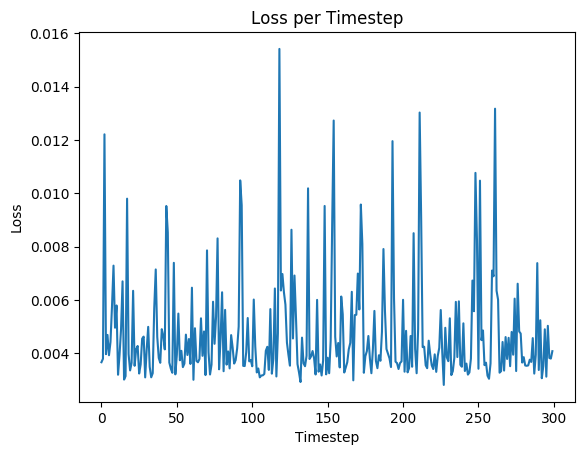

In [10]:
def validate_model(model: nn.Module,
                   validation_loader: torch.utils.data.DataLoader,
                   device: torch.device) -> Tuple[List[float], List[float]]:
    losses = {i:0 for i in range(0, labels.shape[2], 1)}
    for i, (x, y) in enumerate(validation_loader):
        x = x.to(device)
        output = model(x)[0]
        output = output.to("cpu").detach().numpy()
        y = y.to("cpu").detach().numpy()
        for t in range(0, labels.shape[2], 1):
            y_true = y[:,:,t]
            y_pred = output[:,:,t]
            squared_error = ((y_true - y_pred) ** 2)
            # print(squared_error.shape)
            losses[t] += np.sum(squared_error)
    #  TODO Losses normalized by std of each timestep
    return losses


losses = validate_model(model, valid_data, device)

lists = sorted(losses.items())
timestep, loss_val = zip(*lists)
plt.plot(timestep, loss_val)
plt.xlabel('Timestep')
plt.ylabel('Loss')
plt.title('Loss per Timestep')

plt.show()

In [11]:
x, y = next(iter(valid_data))
model.eval()
x = x.to(device)
output = model(x)[0]
x = x.to("cpu").detach().numpy()
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

print(x.shape)
print(y.shape)
print(output.shape)

(32, 1, 300)
(32, 1, 300)
(32, 1, 300)


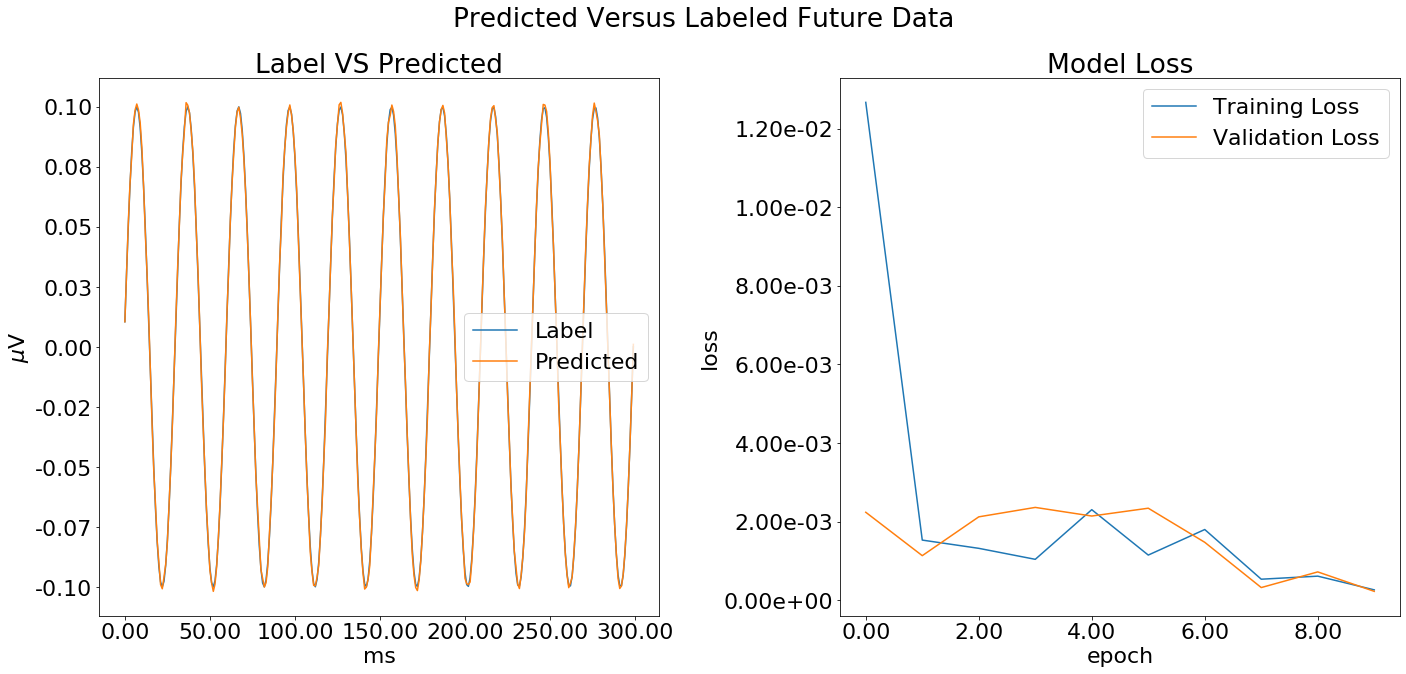

In [12]:
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

scaled_t_loss = [l/(split_idx/batch_size) for l in t_loss]
scaled_v_loss = [l/((data.shape[0] - split_idx)/batch_size) for l in v_loss]

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 22

fig = plt.figure(figsize=(20,10))
gs = GridSpec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

fig.suptitle('Predicted Versus Labeled Future Data')

t = np.arange(0, samples)

ax1.plot(t, y[0,0,:], label='Label')
ax1.plot(t, output[0,0,:], label='Predicted')
ax1.set_xlabel('ms')
ax1.set_ylabel(r'$\mu$V')
ax1.set_title('Label VS Predicted')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.legend(loc='best')

ax2.plot(np.arange(epochs), np.array(scaled_t_loss), label='Training Loss')
ax2.plot(np.arange(epochs), np.array(scaled_v_loss), label='Validation Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Model Loss')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.legend(loc='best')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()